In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from json import load
import tifffile
from tqdm import tqdm
from skimage.draw import polygon
from matplotlib import rcParams
from glasbey import create_palette

palette = {
    "green": "#558150",
    "beige": "#F1E2C3",
    "brown": "#A7785A",
    "pink": "#F0D6C2",
    "black": "#0E0E0E",
}

rcParams['font.family'] = 'sans-serif'
rcParams['figure.facecolor'] = "#FFFFFF00"
rcParams['axes.facecolor'] = "#FFFFFF00"
rcParams['legend.framealpha'] = 0.2
rcParams['axes.edgecolor'] = palette["black"]
rcParams['axes.labelcolor'] = palette["black"]
rcParams['xtick.color'] = palette["black"]
rcParams['ytick.color'] = palette["black"]
rcParams['text.color'] = palette["black"]
rcParams['axes.titlecolor'] = palette["black"]

s_palette = sns.cubehelix_palette(as_cmap=True)
pal = sns.color_palette("dark")
cpal = sns.cubehelix_palette(start=-0.25, rot=2, as_cmap=True)
g_palette = create_palette(4000)

In [3]:
save_path = Path(r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2024_11_04\recon2\backtracking")

In [4]:
source_path = Path(r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2024_11_04\recon2\backtracking")

tracked = pd.read_csv(source_path / "points.csv")
tracked[["frame", "framelabel"]] = tracked["ID"].str.split(":", expand=True)
tracked[["parent_frame", "parent_framelabel"]] = tracked["parent"].str.split(":", expand=True)
tracked["hasparent"] = tracked["parent_framelabel"] != "00000"
tracked = tracked.set_index("ID")
tracked["ID"] = tracked.index

In [5]:
tracked

,Unnamed: 0,z,y,x,val,parent,parent_z,parent_y,parent_x,frame,framelabel,parent_frame,parent_framelabel,hasparent,ID
ID,,,,,,,,,,,,,,,
000:00000,0,0.0,0.0,0.0,0.000000,000:00000,0.0,0.0,0.0,000,00000,000,00000,False,000:00000
000:00001,1,283.0,162.0,224.0,136.768707,000:00000,0.0,0.0,0.0,000,00001,000,00000,False,000:00001
000:00002,2,88.0,358.0,58.0,135.497040,000:00000,0.0,0.0,0.0,000,00002,000,00000,False,000:00002
000:00003,3,115.0,194.0,64.0,133.141541,000:00000,0.0,0.0,0.0,000,00003,000,00000,False,000:00003
000:00004,4,306.0,313.0,102.0,130.992294,000:00000,0.0,0.0,0.0,000,00004,000,00000,False,000:00004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277:09343,9343,307.0,525.0,226.0,20.020203,276:08954,308.0,525.0,227.0,277,09343,276,08954,True,277:09343
277:09344,9344,82.0,120.0,245.0,20.017181,276:05231,87.0,122.0,236.0,277,09344,276,05231,True,277:09344
277:09345,9345,303.0,510.0,158.0,20.010376,276:08603,304.0,509.0,158.0,277,09345,276,08603,True,277:09345


In [6]:
import networkx as nx

G = nx.DiGraph()
G.add_nodes_from(tracked["ID"].values)
G.add_edges_from(tracked[tracked["hasparent"]][["ID", "parent"]].values)

In [8]:
tracked["track_id"] = 0

for i, cc in tqdm(enumerate(sorted(nx.connected_components(G.to_undirected()), key=len, reverse=True), start=1)):
    for c in cc:
        tracked.loc[c, "track_id"] = i

15172it [02:30, 100.66it/s]  


In [9]:
tracked['frame'] = tracked['frame'].astype(int)
last_frame = tracked["frame"].max()
last_frame_pts = tracked[tracked["frame"] == last_frame]
final_pts = last_frame_pts[last_frame_pts["val"] > 77]

print(final_pts.groupby("track_id")["ID"].count().value_counts())

tracked["is_downstream"] = False

for pt_id in tqdm(final_pts["ID"]):
    downstream_points = list(nx.descendants(G, pt_id))
    tracked.loc[downstream_points, "is_downstream"] = True


ID
16    23
32    15
31    12
29    11
30    10
14     8
34     7
1      6
4      6
24     5
2      5
15     5
28     5
27     5
33     5
64     4
20     4
47     4
17     3
22     3
48     3
40     2
26     2
36     2
37     2
46     2
49     2
8      2
11     2
43     2
25     2
65     2
18     2
9      1
13     1
10     1
66     1
38     1
35     1
45     1
23     1
62     1
42     1
19     1
51     1
55     1
68     1
58     1
56     1
59     1
60     1
5      1
Name: count, dtype: int64


100%|██████████| 5231/5231 [00:05<00:00, 882.42it/s] 


['014:10459']
drawing


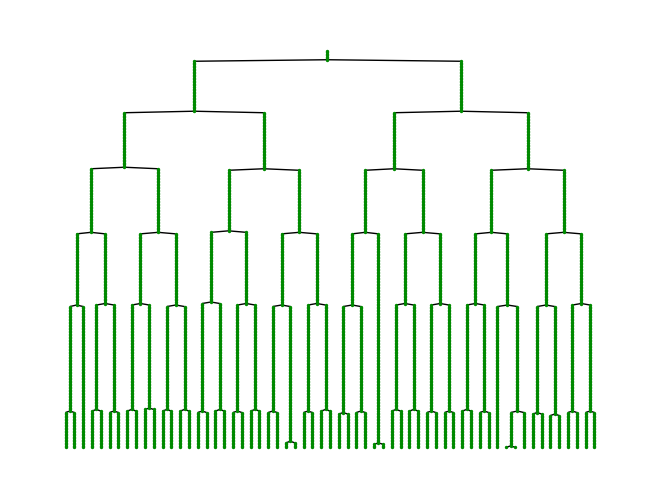

In [10]:
def plot_lineage(tracked, track_id):
    track = tracked[tracked["track_id"] == track_id]
    track = track[track["is_downstream"]]
    
    g = nx.subgraph(G, track["ID"].values)
    last_node = [n for n in g if g.out_degree(n) == 0]
    print(last_node)
    last_node = last_node[0]
    
    dfs_postorder = list(nx.dfs_postorder_nodes(g.reverse(), last_node))
    dfs_order_map = {n: i for i, n in enumerate(dfs_postorder)}
    
    # base nodes
    base_nodes = [n for n in g if g.in_degree(n) == 0]
    nx.set_node_attributes(g, 0, "x")
    frames = track.loc[list(g.nodes), "frame"]
    nx.set_node_attributes(g, {n: f for n, f in zip(g.nodes, -frames)}, "y")
    
    for i, n in enumerate(sorted(base_nodes, key=lambda x: dfs_order_map[x]), 1):
        g.nodes[n]["x"] = i
        
    for n in sorted(g, key=lambda x: g.nodes[x]["y"]):
        if n in base_nodes:
            continue
        g.nodes[n]["x"] = np.mean([g.nodes[p]["x"] for p in g.predecessors(n)])
    
    pos = {n: (g.nodes[n]["x"], g.nodes[n]["y"]) for n in g}
    print("drawing")
    nx.draw(g, pos, with_labels=False, node_size=2, node_color=g_palette[track_id], arrows=False)
    plt.show()

plot_lineage(tracked, 2)

In [ ]:
G

In [ ]:
import plotly.express as px

spots_df = tracked.copy()

spots_df["reflection_z"] = 2.1*spots_df["z"].max() - spots_df["z"]
spots_df["reflection_x"] = spots_df["x"].max() - spots_df["x"]

spots_df["is_reflected"] = spots_df["x"] > spots_df["x"].max() / 2

spots_df["display_x"] = spots_df["reflection_x"]*spots_df["is_reflected"] + spots_df["x"]*(~spots_df["is_reflected"])
spots_df["display_z"] = spots_df["reflection_z"]*spots_df["is_reflected"] + spots_df["z"]*(~spots_df["is_reflected"])

n_tracks = 250
best_spots = spots_df[spots_df["is_downstream"]]
# n_tracklets = best_spots["track_id"].map(best_spots.groupby("track_id")["tracklet_id"].nunique())
# best_spots = best_spots[n_tracklets > 1]
# best_spots = best_spots[best_spots["track_id"] == 2]
# best_spots = best_spots[best_spots["x"] < 180]
# best_spots = best_spots[best_spots["y"] < 100]
fig = px.scatter_3d(best_spots, x='display_x', y='y', z='display_z', color='track_id', animation_frame="frame", color_continuous_scale=g_palette, range_color=[0, n_tracks])

fig.update_layout(scene=dict(aspectmode='data'))
fig.update_layout(transition={'duration': 100})
fig.update_traces(marker=dict(size=10, colorscale=g_palette), 
                  line=dict(width=50, color='DarkSlateGrey'),
                  )
fig.write_html(save_path / "track_allspots.html")

In [ ]:
source_path = Path(r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2024_11_04\recon2\backtracking")
source1 = tifffile.imread(source_path / "recon_fused_tp_180_ch_0.tif")
source2 = tifffile.imread(source_path / "recon_fused_tp_181_ch_0.tif")

In [ ]:
print(source1.shape)

In [ ]:
from skimage.filters import difference_of_gaussians

dog1 = difference_of_gaussians(source1, 2, 6)

In [ ]:
spots_df = pd.read_csv(r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2024_11_04\recon2\dis3\out\tracked_spots.csv")
example_points = spots_df[spots_df["FRAME"] == 181]
example_points = example_points[example_points["track_id"] != 0]
X = example_points[["POSITION_X", "POSITION_Y", "POSITION_Z"]].values

In [ ]:
import napari
from scipy.ndimage import sobel

viewer = napari.Viewer()

s = np.zeros_like(source1)

for axis in range(3):
    s += sobel(-dog1, axis=axis)**2
viewer.add_image(np.sqrt(s), name="source1_sobel", colormap="magenta")
viewer.add_image(source1, name="source1", colormap="green")
napari.run()

In [ ]:
from skimage.feature import peak_local_max
from scipy.ndimage import distance_transform_edt
from skimage import segmentation

peaks = peak_local_max(dog1, min_distance=2, threshold_abs=20)
img = np.zeros(source1.shape)
img[peaks[:, 0], peaks[:, 1], peaks[:, 2]] = np.arange(1, len(peaks) + 1)
dist = distance_transform_edt(img == 0)
w = segmentation.watershed(-dog1, img.astype(int), mask=dist < 18)

In [ ]:
np.array(list(peaks_map.values()))

In [ ]:
peaks_map = {i + 1: p for i, p in enumerate(peaks)}
peaks_map[0] = (0, 0, 0)
example_points["new_label"] = [w[tuple(p.astype(int))] for p in X]
example_points["new_x"] = example_points["new_label"].map(lambda x: peaks_map[x][0])
example_points["new_y"] = example_points["new_label"].map(lambda x: peaks_map[x][1])
example_points["new_z"] = example_points["new_label"].map(lambda x: peaks_map[x][2])
X_new = example_points[["new_x", "new_y", "new_z"]].values

In [ ]:
print(np.max(X, axis=0))

In [ ]:
print(peaks_map[150])
print(np.argwhere(img == 150))

In [ ]:
print(sum(example_points["new_label"] == 0))
example_points

In [ ]:
viewer = napari.Viewer()
viewer.add_image(source1)
viewer.add_image(img, name="peaks")
viewer.add_image(w, name="watershed")
viewer.add_points(X[:], size=5, face_color="white", out_of_slice_display=True)
viewer.add_points(X_new[:], size=5, face_color="red", out_of_slice_display=True)
napari.run()